In [1]:
import os
os.chdir(os.path.expanduser('~/FFF/'))
import fff
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import pickle as pkl
import umap
matplotlib.rcParams.update({'font.size': 18})
import gc         # garbage collect library

INFO: Using pytorch backend
/tmp/ipykernel_3410686/3564497149.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [11]:
df_class = pd.read_pickle("data/EMnist_Class")

# transfer labels from classifier dataset
train_l, test_l = (
    torch.from_numpy(df_class["train_l"]),
    torch.from_numpy(df_class["test_l"]),
)
test_l = torch.argmax(test_l, dim=1)

In [10]:
# GT = GroundTruth = subject_model
GT_src = "GTs/16EMnist_F5F"
GT = fff.FreeFormInjectiveFlow.load_from_checkpoint(
    f"{GT_src}/checkpoints/last.ckpt"
    )
GT.eval()

torch.Size([240000, 1, 16, 16])
cond_dim:  0
latent_dim:  5
[100, 32, 32, 100]
[100, 32, 32, 100]
[100, 32, 32, 100]
[100, 32, 32, 100]


FreeFormInjectiveFlow(
  (models): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (model): Sequential(
        (encoder): Sequential(
          (0): Unflatten(dim=-1, unflattened_size=(1, 16, 16))
          (1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (4): ReLU()
          (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (6): ReLU()
          (7): Flatten(start_dim=-3, end_dim=-1)
          (8): Linear(in_features=1024, out_features=100, bias=True)
        )
        (decoder): Sequential(
          (0): Linear(in_features=100, out_features=4096, bias=True)
          (1): Unflatten(dim=-1, unflattened_size=(256, 4, 4))
          (2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (3): ReLU()
          (4): ConvTranspose2d(128, 1, kernel_size=(3, 3), stride=(2, 2), paddi

In [7]:
model = fff.FreeFormInjectiveFlow.load_from_checkpoint(
        "lightning_logs/F5F_4/version_0/checkpoints/last.ckpt"
    )

torch.Size([240000, 1, 16, 16])
cond_dim:  0
latent_dim:  3
[100, 32, 32, 100]
[100, 32, 32, 100]
[100, 32, 32, 100]
[100, 32, 32, 100]


In [8]:
torch.set_grad_enabled(False)

torch.Size([4000, 256])
torch.Size([942, 256])
tensor([], dtype=torch.bool)
encoding...
reconstructing...
encoding...
reconstructing...
sampling...


IndexError: index 3 is out of bounds for dimension 1 with size 3

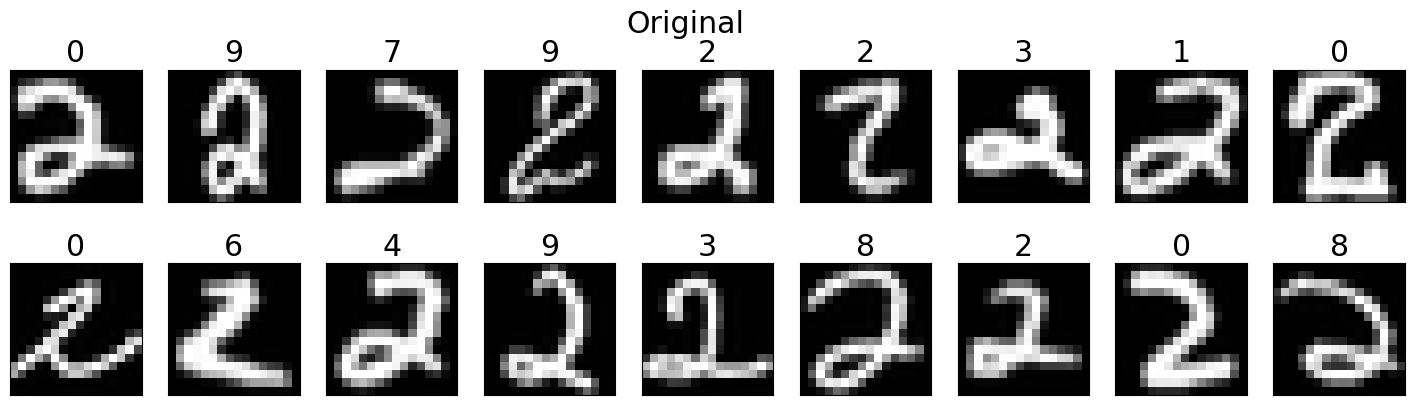

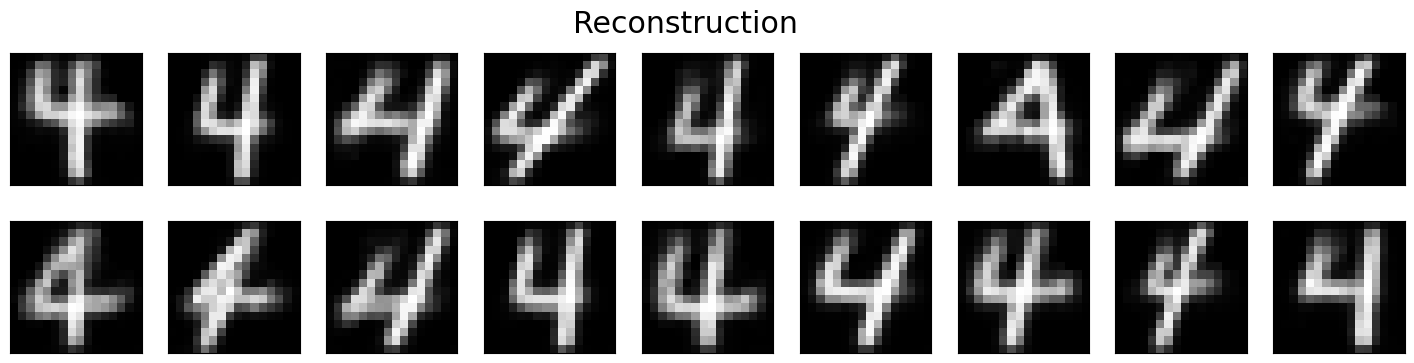

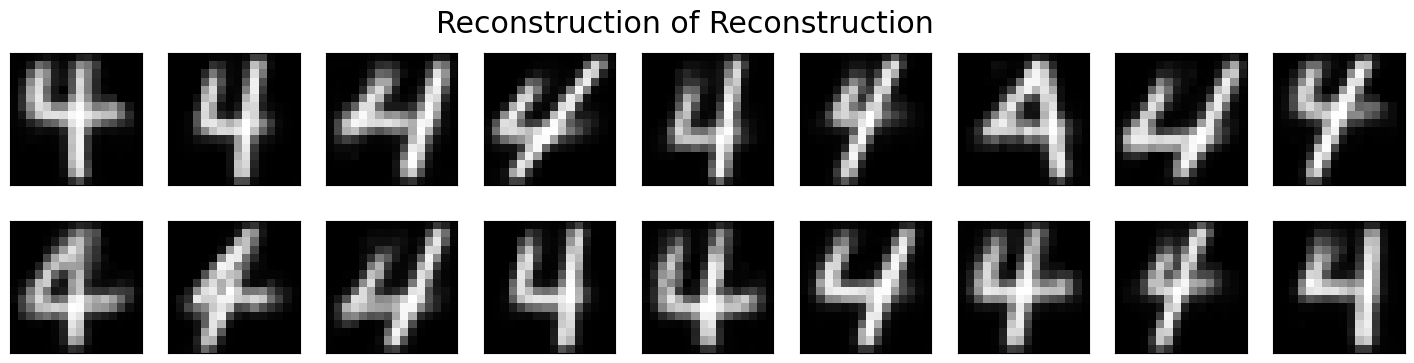

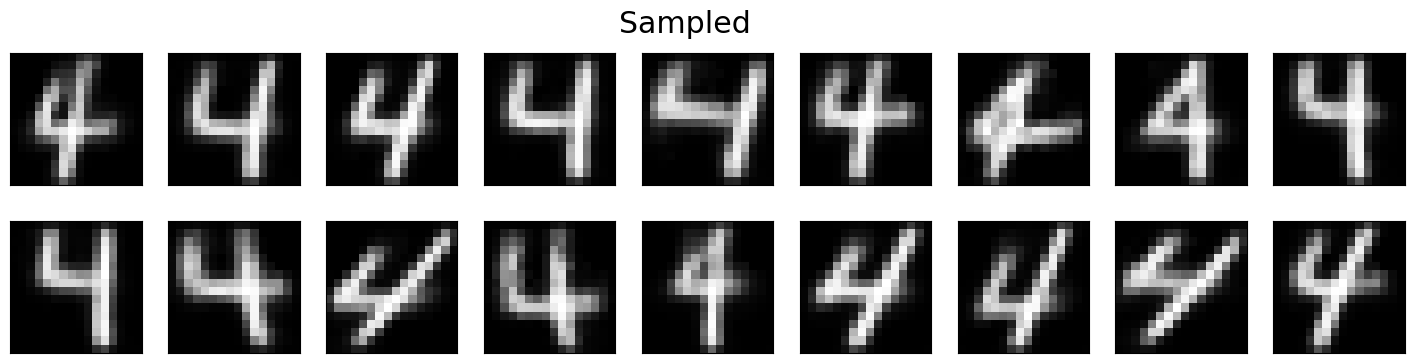

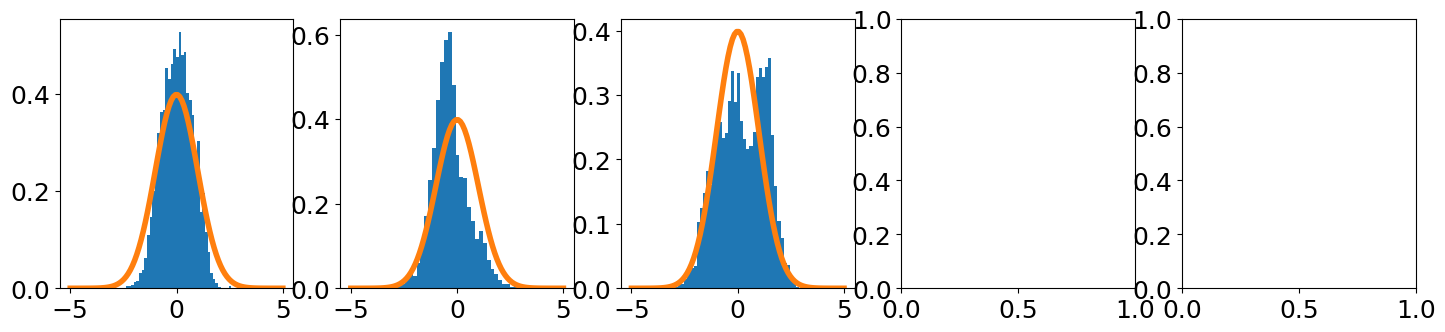

In [21]:
save = False
plot_dir = "emnist/GTs/F5F_4"
from pathlib import Path
import shutil
if save:
    Path(f"plots/{plot_dir}/runfile").mkdir(parents=True, exist_ok=True)
    shutil.copytree(GT_src, f"plots/{plot_dir}/runfile", symlinks=False, ignore=None,ignore_dangling_symlinks=False, dirs_exist_ok=True)
data = plot_mnist(model)
z_test = data["test_z"]
z_dim = z_test.shape[1]
std_z0 = torch.std(z_test[:,0])
std_z1 = torch.std(z_test[:,1])
print("main detail standard deviation: ", std_z0)
print("2nd detail standard deviation: ", std_z1)
#latent_dim = data["test_c"].shape[1]

In [15]:
zrange = 3*std_z0
matplotlib.rcParams.update({'font.size': 15})
nums = [7,2,1,0,4,1,4,9,5,9,0,6,9,0,1,5,9,7,3,4,0,0,0,0,0,0,0,0,0,0,0,0]

for j in range(1):
    plot_details(model, data, j, zrange)

NameError: name 'std_z0' is not defined

In [20]:
from fff.evaluate.plots import all_conditions
def plot_mnist(model2plt):
    device = model2plt.device
    
    data = {}
    train_batch = model2plt.train_data[:]
    val_batch = model2plt.val_data[:]
    test_batch = model2plt.test_data[:]
    #test_batch = (test_data[test_l==2],)
    print(test_batch[0].size())

    train_conditioned = model2plt.apply_conditions(train_batch)
    train_samples = train_conditioned.x_noisy
    train_c = train_conditioned.condition
    
    test_conditioned = model2plt.apply_conditions(test_batch)
    test_c = test_conditioned.condition
    test_samples = test_conditioned.x0
    #test_samples = Gen_samples[rand_perm][:10000]
    #test_samples = test_samples

    # Check datasets:
    first_val_sample = val_batch[0][0]
    print(val_batch[0].shape)
    matches = torch.all(train_batch[0] == first_val_sample, dim=1)
    print(matches[matches==True])
    is_in_train_set = torch.any(matches).item()
    if is_in_train_set:
        print("Warning: val datasets are corrupted!")
    first_val_sample = test_batch[0][0]
    matches = torch.all(train_batch[0] == first_val_sample, dim=1)
    is_in_train_set = torch.any(matches).item()
    if is_in_train_set:
        print("Warning: test datasets are corrupted!")

    batch_size = model2plt.hparams.batch_size
    
    #computing...
    print("encoding...")
    test_z = torch.cat([
        model2plt.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), test_c.split(batch_size))
    ])
    data["test_z"] = test_z.clone()
    
    print("reconstructing...")
    reconstruction = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_z.split(batch_size), test_c.split(batch_size))
    ])
    print("encoding...")
    test_z_1 = torch.cat([
        model2plt.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(reconstruction.split(batch_size), test_c.split(batch_size))
    ])
    print("reconstructing...")
    reconstruction1 = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_z_1.split(batch_size), test_c.split(batch_size))
    ])
   
    print("sampling...")
    #x_sampled = model2plt.sample((test_z[:100].shape[0],))
    z_sampled = torch.randn_like(test_z) * 0.9
    x_sampled = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(z_sampled.split(batch_size), test_c.split(batch_size))
    ])

    print("plotting...")
    nrows = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=9, figsize=(18, nrows*2.2+0.2))
    fig.suptitle("Original")
    for i in range(nrows):
        for j in range(9):
            axes[i][j].imshow((test_samples[i*9 +j]).cpu().reshape(16, 16).T, cmap='gray')
            axes[i][j].set_title(f"{test_l[i*9 +j]}")
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    if save:
        plt.savefig(f"plots/{plot_dir}/original.png", bbox_inches='tight')

    fig, axes = plt.subplots(nrows=nrows, ncols=9, figsize=(18, nrows*2))
    for i in range(nrows):
        for j in range(9):
            axes[i][j].imshow(reconstruction[i*9 +j].cpu().reshape(16, 16).T, cmap='gray')
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    fig.suptitle("Reconstruction")
    if save:
        plt.savefig(f"plots/{plot_dir}/reconstruction.png", bbox_inches='tight')
        
    #plotting...
    fig, axes = plt.subplots(nrows=nrows, ncols=9, figsize=(18, nrows*2))
    for i in range(nrows):
        for j in range(9):
            axes[i][j].imshow(reconstruction1[i*9 +j].cpu().reshape(16, 16).T, cmap='gray')
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    fig.suptitle("Reconstruction of Reconstruction")
    if save:
        plt.savefig(f"plots/{plot_dir}/2xreco.png", bbox_inches='tight')
    
    fig, axes = plt.subplots(nrows=nrows, ncols=9, figsize=(18, nrows*2))
    for i in range(nrows):
        for j in range(9):
            axes[i][j].imshow(x_sampled[i*9 +j].cpu().reshape(16, 16).T, cmap='gray')
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    fig.suptitle("Sampled")
    if save:
        plt.savefig(f"plots/{plot_dir}/sampled.png", bbox_inches='tight')

    
    z_dim = test_z.shape[1]

    n_cols = z_dim
    nrows = max(z_dim//n_cols,1)
    fig, axes = plt.subplots(nrows=nrows, ncols=n_cols, figsize=(n_cols*3.5, nrows*3.5))
    a = np.linspace(-5,5,100)
    for i in range(nrows):
        if n_cols == 1:
            axes[0].hist(test_z[:,i*n_cols+j], bins=40, label="Samples", density=True)
            axes[0].plot(a, normal(a))
        else:
            for j in range(n_cols):
                if nrows==1:
                    axes[j].hist(test_z[:,i*n_cols+j], bins=40, label="Samples", density=True)
                    axes[j].plot(a, normal(a), linewidth=4)
                else:
                    axes[i][j].hist(test_z[:,i*n_cols+j], bins=40, label="Samples", density=True)
                    axes[i][j].plot(a, normal(a), linewidth=4)
    fig.suptitle("Latent")
    fig.tight_layout()
    if save:
        plt.savefig(f"plots/{plot_dir}/latent.png", bbox_inches='tight')

    return data

In [11]:
def normal(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

In [9]:
z = torch.from_numpy(df["test_y"])
y = test_l
reducer = umap.UMAP()
embedding = reducer.fit_transform(z)
print(embedding.shape)

(40000, 2)


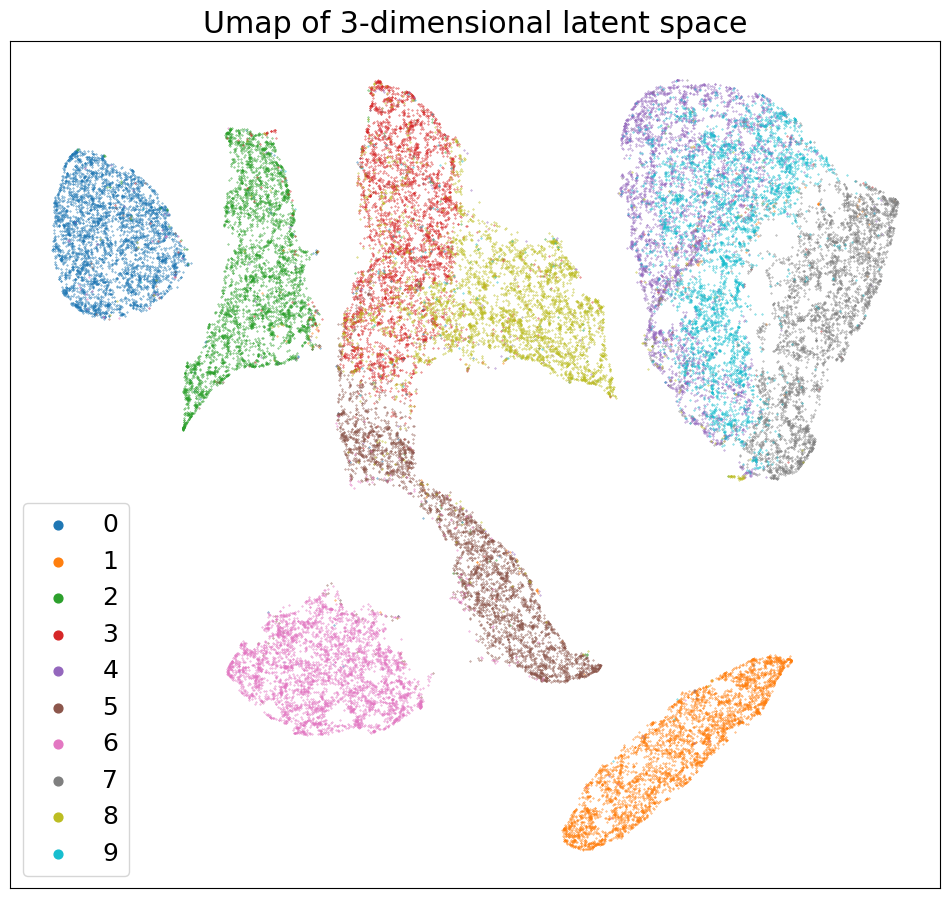

In [10]:
plt.figure(figsize=[12,11])
for i in range(10):
    emb = embedding[y==i]
    plt.scatter(
        emb[:, 0],
        emb[:, 1],
        s=0.1, label=i
    )
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.legend(markerscale=20.,loc='lower left')
plt.title("Umap of 5-dimensional latent space")
plt.savefig(f"plots/emnist/GTs/F5F/umap_latent.png")

In [23]:
data = save_data(model)

torch.Size([230000, 256])
torch.Size([10000, 256])
torch.Size([230000])
tensor([], dtype=torch.bool)
encoding traindata...
encoding valdata...
encoding testdata...


In [22]:
def save_data(rectangular_flow):
    #train_data = rectangular_flow.train_data[:]
    train_data = (torch.from_numpy(df["train_x"]),)
    """
    Gen_samples = pd.read_pickle("data/MNIST/mnist16")
    Gen_samples = (Gen_samples - torch.mean(Gen_samples)) / torch.std(Gen_samples)
    #Gen_samples = Gen_samples * torch.std(train_samples) + torch.mean(train_samples)
    Gen_samples = Gen_samples * 0.3081 + 0.1307
    rand_perm = torch.randperm(Gen_samples.shape[0])
    Gen_samples = Gen_samples.reshape(-1,256)

    print(train_data[0].shape)
    train_data = torch.cat([train_data[0], Gen_samples[rand_perm]], dim=0)
    train_data = (train_data,)
    """
    print(train_data[0].shape)
    #val_data = rectangular_flow.val_data[:]
    val_data = (torch.from_numpy(df["val_x"]),)
    #test_data = rectangular_flow.test_data[:]
    test_data = (torch.from_numpy(df["test_x"]),)

    first_val_sample = val_data[0][0]
    print(val_data[0].shape)
    matches = torch.all(train_data[0] == first_val_sample, dim=1)
    print(matches.shape)
    print(matches[matches==True])
    is_in_train_set = torch.any(matches).item()
    if is_in_train_set:
        print("Warning: val datasets are corrupted!")
    first_val_sample = test_data[0][0]
    matches = torch.all(train_data[0] == first_val_sample, dim=1)
    is_in_train_set = torch.any(matches).item()
    if is_in_train_set:
        print("Warning: test datasets are corrupted!")
    
    conditioned = rectangular_flow.apply_conditions(train_data)
    train_samples = conditioned.x0
    c_t = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_data)
    val_samples = conditioned.x0
    c_v = conditioned.condition

    conditioned = rectangular_flow.apply_conditions(test_data)
    test_samples = conditioned.x0
    c_test = conditioned.condition
    
    device = rectangular_flow.device
    print("encoding traindata...")
    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v.split(batch_size))
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test.split(batch_size))
    ])

    data = {}
    
    data["train_x"] = train_samples.cpu().numpy()
    data["train_y"] = z_train.cpu().numpy()
    
    data["val_x"] = val_samples.cpu().numpy()
    data["val_y"] = z_val.cpu().numpy()

    data["test_x"] = test_samples.cpu().numpy()
    data["test_y"] = z_test.cpu().numpy()

    
    path = "data/"
    fileName = path + '16EMnist_F3F_4'
    fileObject = open(fileName, 'wb')
    
    pkl.dump(data, fileObject)
    fileObject.close()